In [29]:
# Importar librerías para manipulación y análisis de datos
# -----------------------------------------------------------------------
import pandas as pd
from pandas import DataFrame
import numpy as np

# Configuraciones
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None)  # Establece una opción de Pandas para mostrar todas las columnas de un DataFrame.

# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Librerías de visualización
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Métodos de visualización
# -----------------------------------------------------------------------
# establece el estilo del fondo de las gráficas como "whitegrid". Las gráficas tendrán un fondo blanco con líneas de cuadrícula horizontales y verticales.
sns.set_style("whitegrid")

# cambiará el esquema de colores predeterminado de Seaborn a uno más oscuro, adecuado para gráficas con fondos claros. 
sns.set_theme(style="dark")

# establece el estilo en Solarize_Lihgt2. 
plt.style.use('Solarize_Light2')

# Evaluar linealidad de las relaciones entre las variables
# ------------------------------------------------------------------------------
from scipy.stats import shapiro, kstest

import scipy.stats as stats

# Gestión de los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")


# -----------------------------------------------------------------------
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import levene

In [30]:
df = pd.read_csv("marketing_AB.csv",index_col=0)
df.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [31]:
df["test group"].value_counts() #psa es control y ad es test

ad     564577
psa     23524
Name: test group, dtype: int64

In [32]:
# Añadimos "_" en lugar de espacios
columnas = [col.replace(" ", "_") for col in df.columns]
df.columns = columnas

In [33]:
df.columns

Index(['user_id', 'test_group', 'converted', 'total_ads', 'most_ads_day',
       'most_ads_hour'],
      dtype='object')

In [34]:
df["converted"].value_counts() 

False    573258
True      14843
Name: converted, dtype: int64

In [35]:
df_copia = df.copy()

## Ejercicio 1:

Supongamos que estamos realizando un experimento para determinar si un nuevo diseño de anuncio (test group "ad") tiene un impacto significativo en la tasa de conversión en comparación con el diseño de anuncio anterior (test group "psa").

**Objetivo del ejercicio: 
Comparar las tasas de conversión entre los grupos de prueba "ad" y "psa" para determinar si el nuevo diseño de anuncio es más efectivo en la conversión de usuarios.

Pasos que debemos seguir:

1. Preparación de los datos: 
Asegúrate de que los datos estén limpios y listos para el análisis. Esto incluye la eliminación de datos faltantes y la verificación de la coherencia de los datos.

2. Definición de las hipótesis: 
Plantea una hipótesis nula (H0) y una hipótesis alternativa (H1) para el experimento (en este caso os las damos definidas):
- Hipótesis nula (H0): No hay diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".
- Hipótesis alternativa (H1): Existe una diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".

3. Cálculo de la tasa de conversión: 
Calcula la tasa de conversión para cada grupo:
- Para el grupo "ad", la tasa de conversión es el número de usuarios convertidos dividido por el número total de usuarios en ese grupo.
- Para el grupo "psa", realiza el mismo cálculo.

4. Prueba de hipótesis: 
Utiliza una prueba estadística, como la prueba t de Student o la prueba chi-cuadrado, para comparar las tasas de conversión entre los grupos "ad" y "psa".

5. Análisis de resultados:
- Si el valor p es menor que un umbral predefinido (por ejemplo, 0.05), rechazamos la hipótesis nula y concluimos que hay una diferencia significativa en las tasas de conversión entre los grupos.
- Si el valor p es mayor que el umbral, no podemos rechazar la hipótesis nula y concluimos que no hay evidencia suficiente para afirmar que hay una diferencia significativa.

6. Conclusiones y recomendaciones: 
Basándote en los resultados de la prueba de hipótesis, llega a una conclusión sobre si el nuevo diseño de anuncio es más efectivo en la conversión de usuarios que el diseño anterior. Si es así, puedes hacer recomendaciones basadas en estos hallazgos.

In [36]:
#1. Preparación de datos

In [37]:
df_copia.describe()

,user_id,total_ads,most_ads_hour
count,5.881010e+05,588101.000000,588101.000000
mean,1.310692e+06,24.820876,14.469061
std,2.022260e+05,43.715181,4.834634
min,9.000000e+05,1.000000,0.000000
25%,1.143190e+06,4.000000,11.000000
50%,1.313725e+06,13.000000,14.000000
75%,1.484088e+06,27.000000,18.000000
max,1.654483e+06,2065.000000,23.000000


In [38]:
df_copia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        588101 non-null  int64 
 1   test_group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total_ads      588101 non-null  int64 
 4   most_ads_day   588101 non-null  object
 5   most_ads_hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 27.5+ MB


In [39]:
# una vez que tengamos nuestro DataFrame preparado con todas las columnas que queremos vamos a crear una función que no haga una exploración inicial del conjunto de datos
def exploracion_dataframe(dataframe, columna_control):
    
    print(f"Los duplicados que tenemos en el conjunto de datos son: {dataframe.duplicated().sum()}")
    print("\n ..................... \n")
    
    
    # generamos un DataFrame para los valores nulos
    print("Los nulos que tenemos en el conjunto de datos son:")
    df_nulos = pd.DataFrame(dataframe.isnull().sum() / dataframe.shape[0] * 100, columns = ["%_nulos"])
    display(df_nulos["%_nulos"])
    
    print("\n ..................... \n")
    print(f"Los tipos de las columnas son:")
    display(pd.DataFrame(dataframe.dtypes, columns = ["tipo_dato"]))
    
    
    print("\n ..................... \n")
    print("Los valores que tenemos para las columnas categóricas son: ")
    dataframe_categoricas = dataframe.select_dtypes(include = "O")
    
    for col in dataframe_categoricas.columns:
        print(f"La columna {col} tiene las siguientes valore únicos:")
        display(pd.DataFrame(dataframe[col].value_counts()).head())    
    
    # como estamos en un problema de A/B testing y lo que realmente nos importa es comparar entre el grupo de control y el de test, los principales estadísticos los vamos a sacar de cada una de las categorías
    
    for categoria in dataframe[columna_control].unique():
        
        dataframe_filtrado = dataframe[dataframe[columna_control] == categoria]
    
        print("\n ..................... \n")
        print(f"Los principales estadísticos de las columnas categóricas para el {categoria} son: ")
        display(dataframe_filtrado.describe(include = "O").T)
        
        print("\n ..................... \n")
        print(f"Los principales estadísticos de las columnas numéricas para el {categoria} son: ")
        display(dataframe_filtrado.describe().T)

In [40]:
exploracion_dataframe(df_copia,"test_group")

Los duplicados que tenemos en el conjunto de datos son: 0

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


user_id          0.0
test_group       0.0
converted        0.0
total_ads        0.0
most_ads_day     0.0
most_ads_hour    0.0
Name: %_nulos, dtype: float64


 ..................... 

Los tipos de las columnas son:


,tipo_dato
user_id,int64
test_group,object
converted,bool
total_ads,int64
most_ads_day,object
most_ads_hour,int64



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna test_group tiene las siguientes valore únicos:


,test_group
ad,564577
psa,23524


La columna most_ads_day tiene las siguientes valore únicos:


,most_ads_day
Friday,92608
Monday,87073
Sunday,85391
Thursday,82982
Saturday,81660



 ..................... 

Los principales estadísticos de las columnas categóricas para el ad son: 


,count,unique,top,freq
test_group,564577,1,ad,564577
most_ads_day,564577,7,Friday,88805



 ..................... 

Los principales estadísticos de las columnas numéricas para el ad son: 


,count,mean,std,min,25%,50%,75%,max
user_id,564577.0,1.327314e+06,188918.061566,1000000.0,1163686.0,1327362.0,1490914.0,1654483.0
total_ads,564577.0,2.482337e+01,43.750456,1.0,4.0,13.0,27.0,2065.0
most_ads_hour,564577.0,1.447590e+01,4.841808,0.0,11.0,14.0,18.0,23.0



 ..................... 

Los principales estadísticos de las columnas categóricas para el psa son: 


,count,unique,top,freq
test_group,23524,1,psa,23524
most_ads_day,23524,7,Thursday,3905



 ..................... 

Los principales estadísticos de las columnas numéricas para el psa son: 


,count,mean,std,min,25%,50%,75%,max
user_id,23524.0,911761.500000,6790.938202,900000.0,905880.75,911761.5,917642.25,923523.0
total_ads,23524.0,24.761138,42.860720,1.0,4.00,12.0,26.00,907.0
most_ads_hour,23524.0,14.304923,4.656239,0.0,11.00,14.0,18.00,23.0


In [41]:
#Cambiamos la columna de "converted" de booleano a object
# mapa = {True: "Yes", False: "No"}

# df_copia["converted"] = df_copia["converted"].map(mapa)

# #Comprovabmos que se ha cambiado el tipo
# df_copia["converted"].dtypes

# #Verificamos que son los mismos valores
# df_copia["converted"].value_counts()

In [42]:
#2. Definición de hipótesis
#Hipótesis nula (H0): No hay diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".
#Hipótesis alternativa (H1): Existe una diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa"

In [43]:
#3. Cálculo de la tasa de conversión
df_control = df_copia[df_copia["test_group"] == "psa"]
df_control_converted = df_control[df_control["converted"] == True]
conversion_control = df_control_converted.shape[0] / df_control.shape[0]
conversion_control

0.01785410644448223

In [44]:
df_test = df[df["test_group"] == "ad"]
df_test_converted = df_test[df_test["converted"] == True]
conversion_test = df_test_converted.shape[0] / df_test.shape[0]
conversion_test

0.025546559636683747

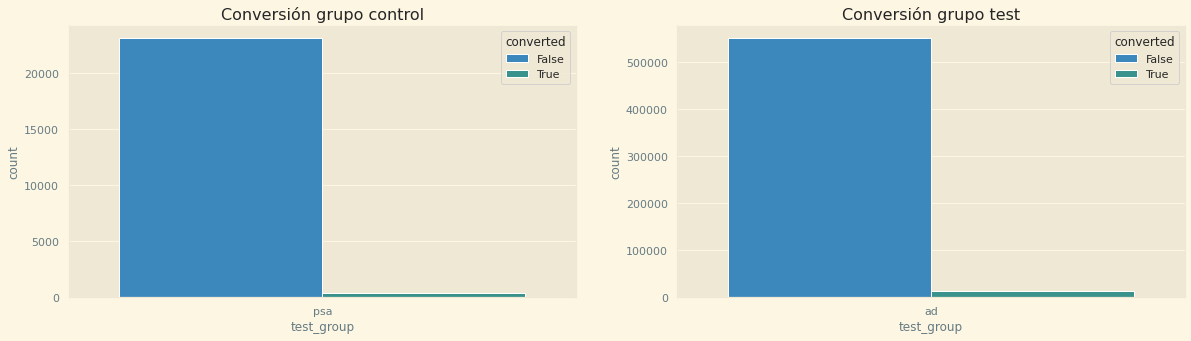

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

# Gráfico 1: Tasa de conversión grupo control
sns.countplot(x="test_group", hue="converted", data=df_control, ax=axes[0])
axes[0].set_title("Conversión grupo control")

# Gráfico 2: Tasa de Conversión grupo test
sns.countplot(x="test_group", hue="converted", data=df_test, ax=axes[1])
axes[1].set_title("Conversión grupo test");

In [47]:
#4. Prueba de hipótesis para comparar las tasas de conversión
#Utilizamos el t-student si nuestro KPI cumple las condiciones de normalidad, homogeneidad de varianzas e independencia. Sino cumple con alguno de estas 3 condiciones, tendríamos q utilizar test no paramétrico como chicuadrado

In [48]:
# Paso 4.1 Verificar la normalidad, homogeneidad de varianzas e independencia

#A. NORMALIDAD con Kolmogrov

def normalidad(dataframe, columna):
    statistic, p_value = kstest(dataframe[columna], "norm")
    if p_value > 0.05:
        print(f"Para la columna {columna} los datos siguen una distribución normal.")
    else:
        print(f"Para la columna {columna} los datos no siguen una distribución normal.")

In [20]:
normalidad(df_copia, "converted")

Para la columna converted los datos no siguen una distribución normal.


In [49]:
normalidad(df_control, "converted")

Para la columna converted los datos no siguen una distribución normal.


In [50]:
normalidad(df_test, "converted")

Para la columna converted los datos no siguen una distribución normal.


In [25]:
#Puesto que no sigue una distribución normal, no tenemos que hacer los test the homogeneidad de varianza e independencia y habría que hacer directamente la prueba de ManWhitney

In [51]:
statistic, pvalue = stats.mannwhitneyu(df_control["converted"], df_test["converted"])

In [52]:
pvalue

1.7053617930171878e-13

In [ ]:
#Puesto que el pvalue es menor a 0.05, las medias son significativamente diferentes, se rechaza la hipótesis nula

## Ejercicio 2:

En este caso, vamos a realizar un experimento para comparar la cantidad promedio de anuncios vistos por los usuarios en los grupos "ad" y "psa" y determinar si hay una diferencia significativa entre ellos.

**Objetivo del experimento: 
Comparar la cantidad promedio de anuncios vistos por usuario entre los grupos de prueba "ad" y "psa" para determinar si el tipo de anuncio afecta la cantidad de anuncios que los usuarios ven.

1. Preparación de los datos: 
Asegúrate de que los datos estén limpios y listos para el análisis. Esto incluye la eliminación de datos faltantes y la verificación de la coherencia de los datos.

2. Hipótesis:
Plantea una hipótesis nula (H0) y una hipótesis alternativa (H1) para el experimento. En este caso, las deberéis plantear vosotras

3. Prueba de hipótesis: 
Utiliza una prueba estadística, como la prueba t de Student, para comparar la cantidad promedio de anuncios vistos por usuario entre los grupos "ad" y "psa". Esto te permitirá determinar si hay una diferencia significativa entre los dos grupos.

4. Análisis de resultados:
- Si el valor p (p-value) es menor que un umbral predefinido (por ejemplo, 0.05), rechazamos la hipótesis nula y concluimos que hay una diferencia significativa en la cantidad promedio de anuncios vistos por usuario entre los grupos.
- Si el valor p es mayor que el umbral, no podemos rechazar la hipótesis nula y concluimos que no hay evidencia suficiente para afirmar que hay una diferencia significativa.

5. Conclusiones y recomendaciones: 
Basándote en los resultados de la prueba de hipótesis, llega a una conclusión sobre si el tipo de anuncio (ad o psa) tiene un impacto significativo en la cantidad promedio de anuncios vistos por usuario. Si es así, puedes hacer recomendaciones basadas en estos hallazgos.